# Assignment 3 - Text Classification
### Carlos Solorzano (S1108905)
### Data Mining

The purpose of the assignment is to learn about classification using text data. The classification model (classifier) to be used is an Artificial Neural Network. 

The first step, is to import the required libraries. <code>pandas</code> is used to read and load the dataset as a <b>Dataframe</b>. The <code>re</code> library is used for <i>regex</i> (regular expressions) on strings. The <code>json</code> library is used to deal with JSON files (save and load). This notebook can be found in https://github.com/sololzano/DM_Assignment_3.

In [49]:
from sklearn.metrics import confusion_matrix, accuracy_score
from matplotlib import pyplot as plt
from zipfile import ZipFile
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import json
import os
import io
import re
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# Import and Preprocess Data

In [2]:
# Import the data from my personal GitHub
df = pd.read_csv('https://media.githubusercontent.com/media/sololzano/DM_Assignment_3/main/ag_news_csv/train.csv', 
                 names=['Class', 'Title', 'Description'], header=None)
r = requests.get('https://raw.githubusercontent.com/sololzano/DM_Assignment_3/main/ag_news_csv/classes.txt')
classes = r.text.split()
print(classes)
df.head()

['World', 'Sports', 'Business', 'Sci/Tech']


,Class,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


The dataset includes 3 columns: <b>Class</b>, <b>Title</b> and <b>Description</b>. The classes range from 1 to 4 (<i>world</i>, <i>sports</i>, <i>business</i> and <i>sci/tech</i>). The <b>Title</b> column / feature includes the title of the news, and <b>Description</b> is nothing more than a short summary of the news. Note that, in the <b>Title</b> column, the news company is written within parentheses. That means, we can remove the name of the news journal / paper, since it does not provide any information. For example, take <i>Reuters</i>; they specialize in financial news, but they also have a sports department. Moreover, we can merge the <b>Title</b> and <b>Description</b> columns, since they are both text. 

In [3]:
# Pre-processing function for the text data
def preprocess(data):
    data['Title'] = data['Title'].apply(lambda x: re.sub('\(.*?\)', '', x).strip())
    data['Description'] = data['Description'].apply(lambda x: re.sub('.*?\- ', '', x))
    data['Description'] = data['Description'].apply(lambda x: re.sub(r'\\', '', x))
    data['Text'] = data['Title'] + ' ' + data['Description']
    data['Text'] = data['Text'].apply(lambda x: x.lower())
    data.drop(['Title', 'Description'], axis=1, inplace=True)
    
    data['Class'] = data['Class'] - 1
    
    return data

In [4]:
# Pre-process the dataframe
df_clean = preprocess(df.copy())
print(df_clean.shape)
df_clean.head()

(120000, 2)


,Class,Text
0,2,wall st. bears claw back into the black short-...
1,2,carlyle looks toward commercial aerospace priv...
2,2,oil and economy cloud stocks' outlook soaring ...
3,2,iraq halts oil exports from main southern pipe...
4,2,"oil prices soar to all-time record, posing new..."


The training dataset now includes only two columns: <b>Class</b> and <b>Text</b>. The text was formatted and standardize as follows:
- The news company name was removed from the <b>Title</b> and <b>Description</b> columns.
- Some symbols were removed (e.g., '\\').
- The text was set to lowercase.
- The <b>Class</b> column range was changed from [1, 4] to [0, 3].

In [5]:
from tensorflow.keras.layers import (TextVectorization, Dense, Lambda, Input, 
                                     Embedding, Dropout, GlobalAveragePooling1D)
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Model
import tensorflow as tf

# This is for my PC only! Please comment these lines if you are not using Ubuntu!!! - Tensorflow in Ubuntu is really bad!
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
print(tf.__version__)

2.12.0


### Attention!!
For the Neural Network, the Keras API was used, with Tensorflow (TF) as backend. For this model, Tensorflow 2.12.0 is needed (the latest version). If you do not have TF 2.12.0, please run this notebook in Google Colab. It takes approximately 2 hours to run the training program for the grid search. For testing only with the pretrained weights, please go to the [Testing](#Testing) section

In [6]:
class TextClassificationModel(Model):
    def __init__(self, features_size: int, corpus: np.array, output_mode: str='tf_idf', 
                max_len: int=1000, embed_dim: int=256, dense_layers: list=[512, 256, 128], classes: int=4) -> None:
        super().__init__()
        
        self.features_size = features_size
        self.output_mode = output_mode
        self.embed_dim = embed_dim
        self.dense_layers = dense_layers
        self.classes = classes
        self.corpus = corpus
        
        # Vectorization / Tokenizer layer
        self.max_len = max_len if output_mode=='int' else None
        self.tokenizer = TextVectorization(max_tokens=features_size, output_mode=output_mode, 
                                      output_sequence_length=self.max_len)
        self.tokenizer.adapt(corpus)
        
        # Embedding layer for integer representation only!
        self.embed = Embedding(features_size+1, embed_dim) if self.max_len else Lambda(lambda x: x)
        
        # MLP for classification
        mlp = [[Dense(layer, activation='leaky_relu')] + [Dropout(0.2)] for layer in dense_layers]
        self.classifier = tf.keras.Sequential(
            [l for block in mlp for l in block]
        )
        self.head = tf.keras.Sequential([
            GlobalAveragePooling1D() if self.max_len else Lambda(lambda x: x),
            Dense(classes)
        ])
        
        # Call on dummy data just to build the model
        self(np.array(['Holaaa aaaaaaaaaaa']))
        
    def get_config(self) -> None:
        return {
            'features_size': self.features_size, 
            'corpus': self.corpus,
            'output_mode': self.output_mode,
            'max_len': self.max_len,
            'embed_dim': self.embed_dim,
            'dense_layers': self.dense_layers,
            'classes': self.classes
        }
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)
        
    def call(self, x: tf.Tensor) -> tf.Tensor:
        # Tokenize the input text
        x = self.tokenizer(x[...])
        
        # Embedding / Lambda layer
        embed = self.embed(x)
        
        # Classifier pre-head
        ann = self.classifier(embed)
        
        # Return the probabilities|
        return self.head(ann)

The Neural Network architecture is encapsulated in a <code>Model</code> class, from the Tensorflow library. This gives a lot more of flexibility to change the parameters or hyperparameters of a neural network. The Neural Network consists of 3 main parts: 
1. <code>TextVectorization</code>: Layer that expects text as input, and then converts the text into a vector (hence, vectorization). The vector size is a parameter, called <code>features_size</code> in the model. The layer can process the text in different ways:
    - <i>int</i>: integer indices, with one integer index per token. The indices are relative to the extracted vocabulary from the training set.
    - <i>multi-hot</i>: one-hot encoding, where a value of 1 is mapped to the index in the vocabulary. 
    - <i>tf_idf</i>: the TF-IDF (Term Frequency - Inverse Document Frequency) algorithm is applied. The output is similar to the one-hot, but instead of ones and zeros, the array contains the calculated TF-IDF for the token (word) in the vocabulary. 
2. <code>Embedding</code>: Layer that turns positive integers or indexes into dense vectors of fixed size. It learns the floating point representation of the integer indices of the words in the vocabulary. Note that this layer is only used for the <i>int</i> output mode from the <code>TextVectorization</code> layer. 
3. <b>MLP</b>: Block of dense (linear) layers for the classification task. Each dense layer is followed by a dropout layer to avoid overfitting and make the model more general. The activation function used for this model is <b>LeakyReLU</b>, which is a modified version of the Rectified Linear Unit <b>ReLU</b>.

To understand each part of the model, we will go through each part with examples.

The optimization of the neural network was done with the ADAM algorithm. The loss function to optimize was the <b>Crossentropy</b>. The <b>Crossentropy</b> measures the distance between two distributions (i.e., the ground-true labels and the predicted probabilities). The equation is shown below,

$$
H(P|\hat{P}) = -\sum_{i}P(i)\cdot\textrm{log}(\hat{P})
$$
where $P$ representes the distribution of the ground-true labels, and $\hat{P}$ the predicted class distribution from the model.

### <code>TextVectorization</code> 

In [7]:
# Vectorize the text with int mode, vocabulary size of 30, with an output sequence of 20
tokenizer = TextVectorization(max_tokens=30, output_mode='int', output_sequence_length=20)
tokenizer.adapt(df_clean['Text'].values)

In [8]:
# Let's print the result of vectorizing the first line of the dataset
tokenizer(df_clean['Text'].values[0])

<tf.Tensor: shape=(20,), dtype=int64, numpy=array([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 0, 0])>

The previous output from the vectorization layer shows an array with integer values, of length 20, as indicated in the <code>output_sequence_length</code> argument. We can also visualize the dictionary extracted from the training set. 

In [9]:
for word in tokenizer.get_vocabulary():
    print(word, end=', ')

, [UNK], the, to, a, of, in, and, on, for, 39s, that, with, as, at, its, is, by, said, us, it, has, from, new, an, his, will, after, was, be, 

Because the vocabulary size used is to small, the words selected are the most frequent and they do not make any sense. Note that [UNK] means Unknown, which is a way to say that the word is not included in the vocabulary. This is only an example of the usage of the <code>TextVectorization</code> layer from Tensorflow.  

In [10]:
# Vectorize the text by using the TF-IDF algorithm
tokenizer = TextVectorization(max_tokens=30, output_mode='tf_idf')
tokenizer.adapt(df_clean['Text'].values)

In [11]:
# Print the result of vectorizing the first line of the dataset
tokenizer(df_clean['Text'].values[0])

<tf.Tensor: shape=(30,), dtype=float32, numpy=
array([29.623095 ,  0.8128447,  0.       ,  0.       ,  1.0507725,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ],
      dtype=float32)>

Now, the output from the TF-IDF mode has the size of the vocabulary (30 words). Each item in the array represents the TF-IDF value for the word in the vocabulary in the training text.  

### <code>Embedding</code> 
The <code>Embedding</code> layer converts integer indices to a floating point vector / array. Therefore, it is only used when the text vectorization is performed by integer indices.

In [12]:
# Create an embedding layer which receives a sequence of length output_sequence_length,
# and outputs a vector of size output_dim
layer = Embedding(input_dim=5, output_dim=2)
layer

In [13]:
# Let's put some fake data and see the results
fake_data = np.random.randint(0, 5, (1, 5))
print(fake_data)
layer(np.random.randint(0, 5, (1, 10)))

[[2 4 3 2 3]]


<tf.Tensor: shape=(1, 10, 2), dtype=float32, numpy=
array([[[ 0.01489438, -0.03396883],
        [ 0.02247644,  0.03383831],
        [ 0.04375508, -0.00251209],
        [ 0.03795837,  0.02406094],
        [ 0.01489438, -0.03396883],
        [ 0.03795837,  0.02406094],
        [ 0.03795837,  0.02406094],
        [ 0.02247644,  0.03383831],
        [ 0.01489438, -0.03396883],
        [ 0.03795837,  0.02406094]]], dtype=float32)>

As observed above, each number is now represented as a floating point array. Each array has 2 values (<i>output_dim</i>). Now, those values can be passed directly to a dense layer for the classification. The <code>Embedding</code> layer learns the mapping from the integer indices to the floating point arrays. 

# Grid Search for NN
A Grid Search approach will be used to find optimal parameters of the Neural Network. As a baseline, a model with the following parameters will be demonstrated first:
- Vocabulary size (<code>features_size</code>): 500
- Text encoding (<code>output_mode</code>): int
- Embedding size (<code>embed_dim</code>): 512
- Text encoding length (<code>max_len</code>): 684
- MLP layers (<code>dense_layers</code>): 256 and 128

## Baseline Model 

In [14]:
model = TextClassificationModel(features_size=500, corpus=df_clean['Text'].values, 
                                output_mode='int', embed_dim=512, dense_layers=[256, 128], max_len=684)
model.compile(optimizer='adam', 
              loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary(expand_nested=True)

Model: "text_classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  multiple                 0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     multiple                  256512    
                                                                 
 sequential (Sequential)     (1, 684, 128)             164224    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| dense (Dense)             (1, 684, 256)             131328    |
|                                                               |
| dropout (Dropout)         (1, 684, 256)             0         |
|                                                               |
| dense_1 (Dense)           (1, 684, 128)             32896     |
|                                        

The baseline model has 421k parameters, with only 3 linear (Dense) layers of size 256, 128 and 4 output nodes. We will train first this model as a baseline, and then we will perform the Grid Search.

In [15]:
callback = tf.keras.callbacks.EarlyStopping(patience=3)
history = model.fit(df_clean['Text'].values, (df_clean['Class'].values)[..., None], 
                    epochs=50, batch_size=500, validation_split=0.1, callbacks=[callback])

Epoch 1/50
216/216 [==============================] - 20s 84ms/step - loss: 0.9787 - accuracy: 0.5774 - val_loss: 0.5767 - val_accuracy: 0.7811
Epoch 2/50
216/216 [==============================] - 18s 82ms/step - loss: 0.5393 - accuracy: 0.8114 - val_loss: 0.5219 - val_accuracy: 0.8062
Epoch 3/50
216/216 [==============================] - 18s 82ms/step - loss: 0.5167 - accuracy: 0.8183 - val_loss: 0.5144 - val_accuracy: 0.8113
Epoch 4/50
216/216 [==============================] - 18s 82ms/step - loss: 0.5098 - accuracy: 0.8203 - val_loss: 0.5221 - val_accuracy: 0.8053
Epoch 5/50
216/216 [==============================] - 18s 85ms/step - loss: 0.5056 - accuracy: 0.8216 - val_loss: 0.5240 - val_accuracy: 0.8040
Epoch 6/50
216/216 [==============================] - 18s 81ms/step - loss: 0.5031 - accuracy: 0.8224 - val_loss: 0.5092 - val_accuracy: 0.8084
Epoch 7/50
216/216 [==============================] - 18s 82ms/step - loss: 0.5027 - accuracy: 0.8221 - val_loss: 0.5187 - val_accuracy:

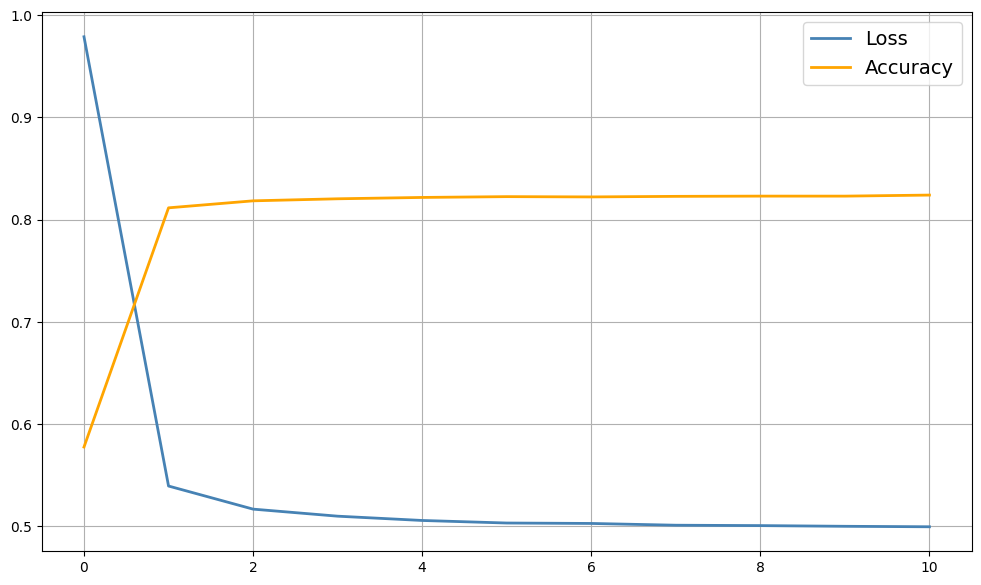

In [16]:
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], linewidth=2, c='steelblue', label='Loss')
plt.plot(history.history['accuracy'], linewidth=2, c='orange', label='Accuracy')
plt.legend(fontsize=14)
plt.grid()

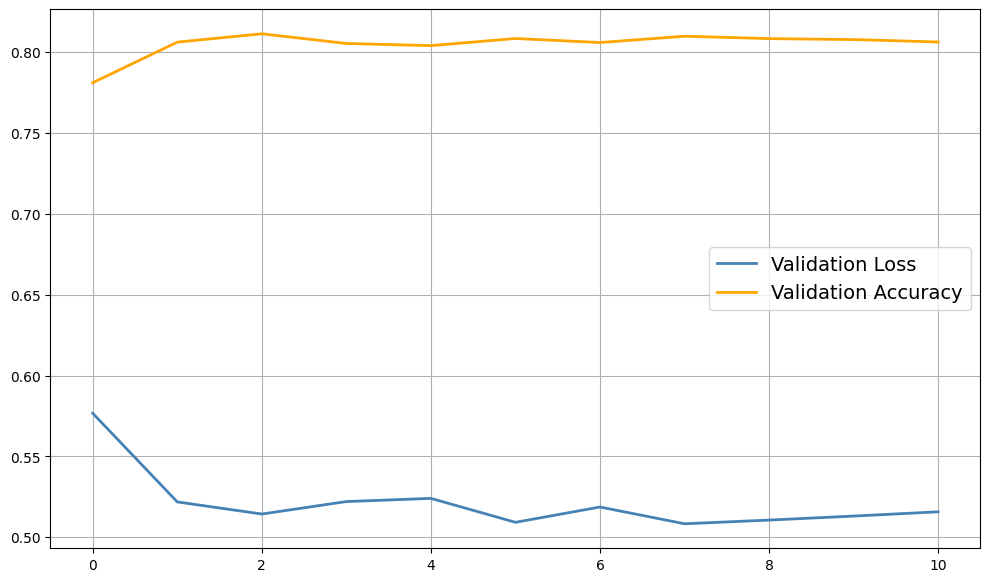

In [17]:
plt.figure(figsize=(12, 7))
plt.plot(history.history['val_loss'], linewidth=2, c='steelblue', label='Validation Loss')
plt.plot(history.history['val_accuracy'], linewidth=2, c='orange', label='Validation Accuracy')
plt.legend(fontsize=14)
plt.grid()

The loss plots indicate that the model was able to learn the classification task from the data. An early stopping callback was used to stop the training when the validation loss did not improve over epochs. Only 11 epochs were needed for this model to be trained. Now we can use the trained model to predict the test data. Given that the model outputs the logits (non-normalized predictions), we need first to use the Softmax function to convert the logits into probabilities. Then, we select the index with the highest probability to determine the predicted class.

In [18]:
# Small helper function, since softmax layer in keras is bad
def softmax(x: np.array) -> np.array:
    return np.exp(x)/(np.sum(np.exp(x), 1))[..., None]

In [19]:
# Here, we create a folder called 'Models' to save the trained models
try:
    os.mkdir('Models')
except:
    pass
model.save(os.path.join('Models', 'Baseline'))

INFO:tensorflow:Assets written to: Models/Baseline/assets


In [30]:
# Predict training data
logits = model.predict(df_clean['Text'])
probs = softmax(logits)

3750/3750 [==============================] - 8s 2ms/step


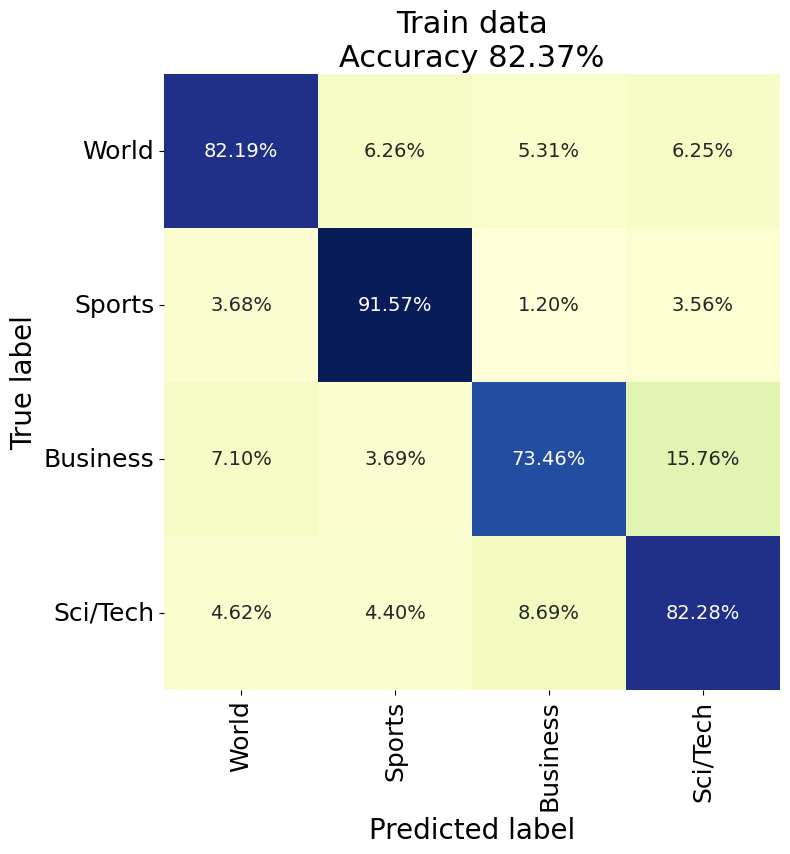

In [31]:
cf = confusion_matrix(df_clean['Class'].values, probs.argmax(1), normalize='true')
acc = accuracy_score(df_clean['Class'].values, probs.argmax(1), normalize=True)
_, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(cf, annot=True, cbar=False, 
            square=True, ax=ax, annot_kws={'fontsize': 14}, 
            fmt='.2%', cmap='YlGnBu')
ax.set_xticklabels(classes, fontsize=18, rotation=90)
ax.set_yticklabels(classes, fontsize=18, rotation=0)
ax.set_xlabel('Predicted label', fontsize=20)
ax.set_ylabel('True label', fontsize=20)
ax.set_title('Train data\nAccuracy {:,.2%}'.format(acc), fontsize=22)
plt.show()

The confusion matrix above shows the results of predicting the training data. It is noticed that the most accurate class for prediction is the <b>Sports</b> class. The model yielded an overall accuracy of 82.37%, with the lowest prediction rate being the class <b>Business</b>.

In [25]:
# Retrieve the test data and preprocess it
df_test = pd.read_csv('https://media.githubusercontent.com/media/sololzano/DM_Assignment_3/main/ag_news_csv/test.csv', 
                      names=['Class', 'Title', 'Description'], header=None)
df_test = preprocess(df_test)
df_test.head()

,Class,Text
0,2,fears for t n pension after talks unions repre...
1,3,the race is on: second private team sets launc...
2,3,ky. company wins grant to study peptides a com...
3,3,prediction unit helps forecast wildfires it's ...
4,3,calif. aims to limit farm-related smog souther...


In [32]:
# Evaluate the test data
test_logits = model.predict(df_test['Text'])
test_probs = softmax(test_logits)

238/238 [==============================] - 1s 2ms/step


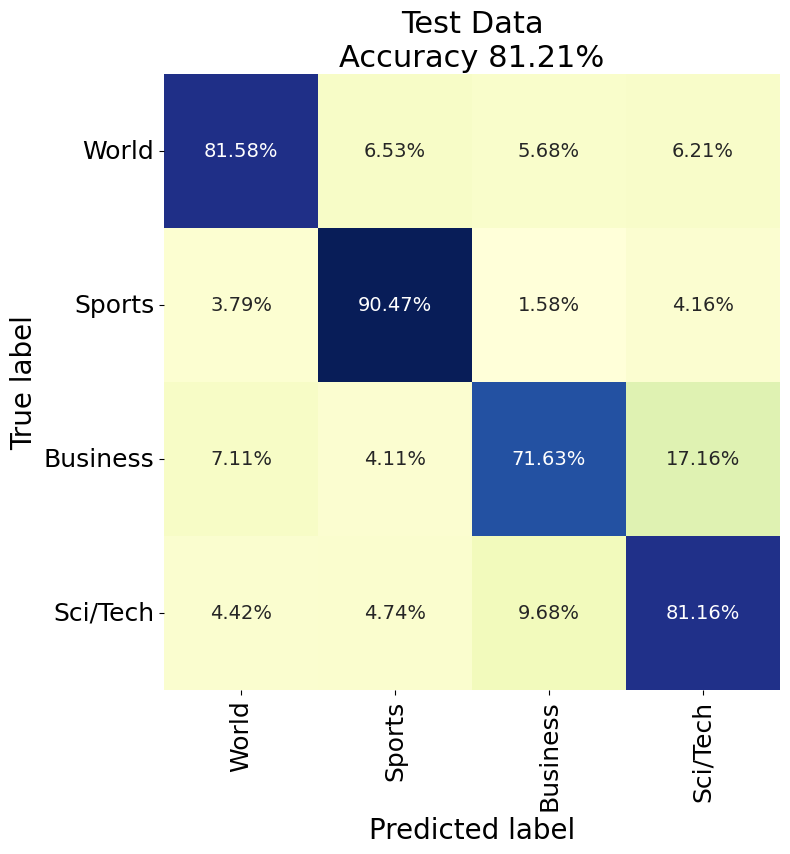

In [33]:
cf = confusion_matrix(df_test['Class'].values, test_probs.argmax(1), normalize='true')
acc = accuracy_score(df_test['Class'].values, test_probs.argmax(1), normalize=True)
_, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(cf, annot=True, cbar=False, 
            square=True, ax=ax, annot_kws={'fontsize': 14}, 
            fmt='.2%', cmap='YlGnBu')
ax.set_xticklabels(classes, fontsize=18, rotation=90)
ax.set_yticklabels(classes, fontsize=18, rotation=0)
ax.set_xlabel('Predicted label', fontsize=20)
ax.set_ylabel('True label', fontsize=20)
ax.set_title('Test Data\nAccuracy {:,.2%}'.format(acc), fontsize=22)
plt.show()

The overall accuracy obtained by evaluating the test data was 81.21%, which is similar to the training data. We can observe that the results of the test data are similar with the train data in values and spread. That means, the most accurate and less accurate predicted class are the same for both datasets (<b>Sports</b> class and <b>Business</b> class, respectively). This indicates that the model was able to generalize from the training data, and there was no overfitting. 

## Grid Search 
Two encoding modes will be evaluated for the vectorization of the text data: <code>int</code> and <code>tf_idf</code>. The encoding modes will be test separately, since the arguments for each mode are different and they do not overlap. The Grid Search will be performed as follows:
- <code>int</code>:
    - Vocabulary size (<code>features_size</code>): 100 and 1000
    - Embedding size (<code>embed_dim</code>): 256 and 1024
    - Encoding length (<code>max_len</code>): 256 and 1024
    - MLP layers (<code>dense_layers</code>): [512, 256, 128] and [1024]
- <code>tf_idf</code>:
    - Vocabulary size (<code>features_size</code>): 100 and 1000
    - MLP layers (<code>dense_layers</code>): [512, 256, 128] and [1024]

In [44]:
# First, delete the model from RAM and everywhere
del model

In [45]:
# Define the grid
vocab_sizes = [100, 1000]
embed_sizes = [256, 1024]
encod_length = [256, 1024]
dense_layers_array = [[512, 256, 128], [1024]]

In [46]:
# Train and evaluate INT models
model_num = 0
train_logits = []
test_logits = []
train_scores = []
test_scores = []
histories = []
for features_size in vocab_sizes:
    for embed_dim in embed_sizes:
        for max_len in encod_length:
            for dense_layers in dense_layers_array:
                print(f'Model {model_num+1}...')
                print(f'Vocab size {features_size}\tEmbed dim {embed_dim}\tMax len {max_len}\tLayers {dense_layers}')
                
                # Train model
                model = TextClassificationModel(features_size=features_size, 
                                                corpus=df_clean['Text'].values, output_mode='int', 
                                                embed_dim=embed_dim, dense_layers=dense_layers, 
                                                max_len=max_len)
                model.compile(optimizer='adam', 
                              loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
                callback = tf.keras.callbacks.EarlyStopping(patience=3)
                history = model.fit(df_clean['Text'].values, (df_clean['Class'].values)[..., None], 
                                    epochs=50, batch_size=500, validation_split=0.1, callbacks=[callback])
                histories.append(history.history)
                
                # Evaluate model for training data
                print('Evaluating...')
                logits = model.predict(df_clean['Text'], verbose=0)
                train_logits.append(logits)
                probs = softmax(logits)
                train_acc = accuracy_score(df_clean['Class'].values, probs.argmax(1), normalize=True)
                train_scores.append(train_acc)
                
                # Evaluate model in test data
                logits = model.predict(df_test['Text'], verbose=0)
                test_logits.append(logits)
                probs = softmax(logits)
                test_acc = accuracy_score(df_test['Class'].values, probs.argmax(1), normalize=True)
                test_scores.append(test_acc)
                
                print('Train acc {:,.2%}\tTest acc {:,.2%}'.format(train_acc, test_acc))
                
                # Save weights of model
                try:
                    os.mkdir('Models', f'Model_{model_num+1}')
                except:
                    pass
                model.save_weights(os.path.join('Models', f'Model_{model_num+1}', 'saved_model'))
                del model
                model_num += 1
                
                print()

Model 1...
Vocab size 100	Embed dim 256	Max len 256	Layers [512, 256, 128]
Epoch 1/50
216/216 [==============================] - 14s 61ms/step - loss: 1.0862 - accuracy: 0.5153 - val_loss: 0.9688 - val_accuracy: 0.5948
Epoch 2/50
216/216 [==============================] - 13s 61ms/step - loss: 0.9152 - accuracy: 0.6256 - val_loss: 0.9453 - val_accuracy: 0.6112
Epoch 3/50
216/216 [==============================] - 13s 61ms/step - loss: 0.9075 - accuracy: 0.6291 - val_loss: 0.9446 - val_accuracy: 0.6157
Epoch 4/50
216/216 [==============================] - 13s 61ms/step - loss: 0.9073 - accuracy: 0.6290 - val_loss: 0.9501 - val_accuracy: 0.6088
Epoch 5/50
216/216 [==============================] - 13s 61ms/step - loss: 0.9065 - accuracy: 0.6295 - val_loss: 0.9534 - val_accuracy: 0.6039
Epoch 6/50
216/216 [==============================] - 13s 61ms/step - loss: 0.9048 - accuracy: 0.6316 - val_loss: 0.9440 - val_accuracy: 0.6112
Epoch 7/50
216/216 [==============================] - 13s 61m

In [47]:
# Train and evaluate TF-IDF models
for features_size in vocab_sizes:
    for dense_layers in dense_layers_array:
        print(f'Model {model_num+1}...')
        print(f'Vocab size {features_size}\tEmbed dim {embed_dim}\tMax len {max_len}\tLayers {dense_layers}')

        # Train model
        model = TextClassificationModel(features_size=features_size, 
                                        corpus=df_clean['Text'].values, output_mode='tf_idf', 
                                        dense_layers=dense_layers)
        model.compile(optimizer='adam', 
                      loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
        callback = tf.keras.callbacks.EarlyStopping(patience=3)
        history = model.fit(df_clean['Text'].values, (df_clean['Class'].values)[..., None], 
                            epochs=50, batch_size=500, validation_split=0.1, callbacks=[callback])
        histories.append(history.history)

        # Evaluate model for training data
        print('Evaluating...')
        logits = model.predict(df_clean['Text'], verbose=0)
        train_logits.append(logits)
        probs = softmax(logits)
        train_acc = accuracy_score(df_clean['Class'].values, probs.argmax(1), normalize=True)
        train_scores.append(train_acc)

        # Evaluate model in test data
        logits = model.predict(df_test['Text'], verbose=0)
        test_logits.append(logits)
        probs = softmax(logits)
        test_acc = accuracy_score(df_test['Class'].values, probs.argmax(1), normalize=True)
        test_scores.append(test_acc)

        print('Train acc {:,.2%}\tTest acc {:,.2%}'.format(train_acc, test_acc))

        # Save weights of model
        try:
            os.mkdir('Models', f'Model_{model_num+1}')
        except:
            pass
        model.save_weights(os.path.join('Models', f'Model_{model_num+1}', 'saved_model'))
        del model
        model_num += 1

        print()

Model 17...
Vocab size 100	Embed dim 1024	Max len 1024	Layers [512, 256, 128]
Epoch 1/50
216/216 [==============================] - 2s 4ms/step - loss: 1.2445 - accuracy: 0.4969 - val_loss: 0.9738 - val_accuracy: 0.6005
Epoch 2/50
216/216 [==============================] - 1s 4ms/step - loss: 0.9470 - accuracy: 0.6082 - val_loss: 0.9436 - val_accuracy: 0.6150
Epoch 3/50
216/216 [==============================] - 1s 4ms/step - loss: 0.9222 - accuracy: 0.6198 - val_loss: 0.9426 - val_accuracy: 0.6156
Epoch 4/50
216/216 [==============================] - 1s 4ms/step - loss: 0.9065 - accuracy: 0.6276 - val_loss: 0.9409 - val_accuracy: 0.6186
Epoch 5/50
216/216 [==============================] - 1s 4ms/step - loss: 0.8931 - accuracy: 0.6334 - val_loss: 0.9333 - val_accuracy: 0.6132
Epoch 6/50
216/216 [==============================] - 1s 4ms/step - loss: 0.8829 - accuracy: 0.6390 - val_loss: 0.9214 - val_accuracy: 0.6195
Epoch 7/50
216/216 [==============================] - 1s 4ms/step - lo

In [62]:
# Save all data from training and evaluation
output_folders = ['Histories', 'Logits']
for folder in output_folders:
    try:
        os.mkdir(folder)
    except:
        pass
    
for i in range(len(histories)):
    # Save history objects
    with open(os.path.join('Histories', f'Model_{i+1}.json'), 'w') as f:
        json.dump(histories[i], f)
        
    # Save training and testing logits as csv
    np.savetxt(os.path.join('Logits', f'Train_Model_{i+1}.csv'), train_logits[i], delimiter=',')
    np.savetxt(os.path.join('Logits', f'Test_Model_{i+1}.csv'), test_logits[i], delimiter=',')
    
# Save accuracy scores as csv
np.savetxt('Training Accuracy.csv', train_scores, delimiter=',')
np.savetxt('Testing Accuracy.csv', test_scores, delimiter=',')

In [67]:
# Obtain the model with the best accuracy
best_model_idx = np.argmax(test_scores)
best_model_acc = test_scores[best_model_idx]
print('Best model index {}, accuracy {:,.2%}'.format(best_model_idx+1, best_model_acc))

Best model index 19, accuracy 86.92%


From all the models tested, the model with the best performance had the parameters:
- Vocabulary size: 1000
- Vectorization mode: tf_idf
- Dense layers: 512, 256, 128
Now, we can visualize the training curves for the loss and accuracy.

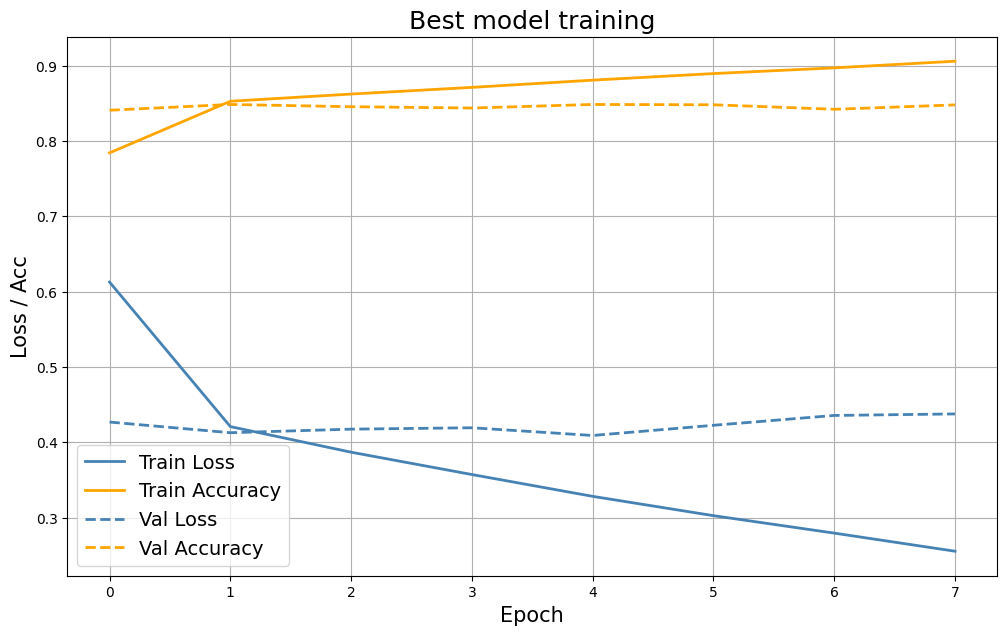

In [73]:
best_history = json.loads(open(os.path.join('Histories', f'Model_{best_model_idx + 1}.json'), 'r').read())
plt.figure(figsize=(12, 7))
plt.plot(best_history['loss'], linewidth=2, c='steelblue', label='Train Loss')
plt.plot(best_history['accuracy'], linewidth=2, c='orange', label='Train Accuracy')
plt.plot(best_history['val_loss'], '--', linewidth=2, c='steelblue', label='Val Loss')
plt.plot(best_history['val_accuracy'], '--', linewidth=2, c='orange', label='Val Accuracy')
plt.legend(fontsize=14)
plt.title('Best model training', fontsize=18)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss / Acc', fontsize=15)
plt.grid()

From the plot of the trainint and validation losses and accuracy, we can observe that the training loss did not converge after 7 epochs of training. However, by also observing the validation loss, we can notice that in fact, the model learned the general idea from the text. The validation loss remained stable. If the training kept going, we could have incurred in overfitting. The Early Stopping strategy helped to prevent the overfitting problem. Now, we can take a look at the confusion matrices of both training and test datasets.

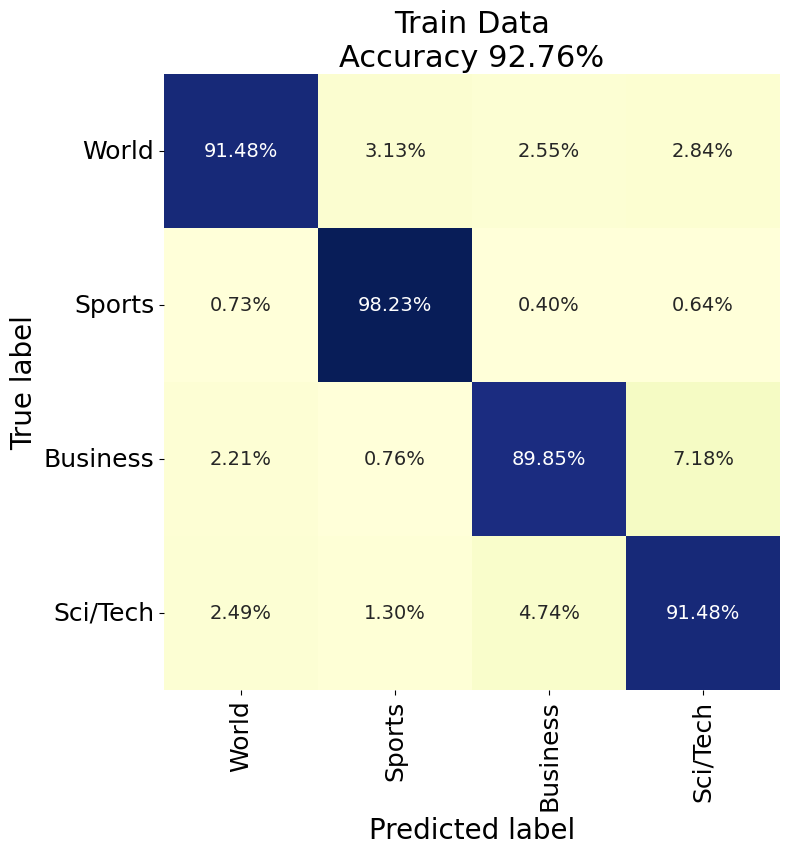

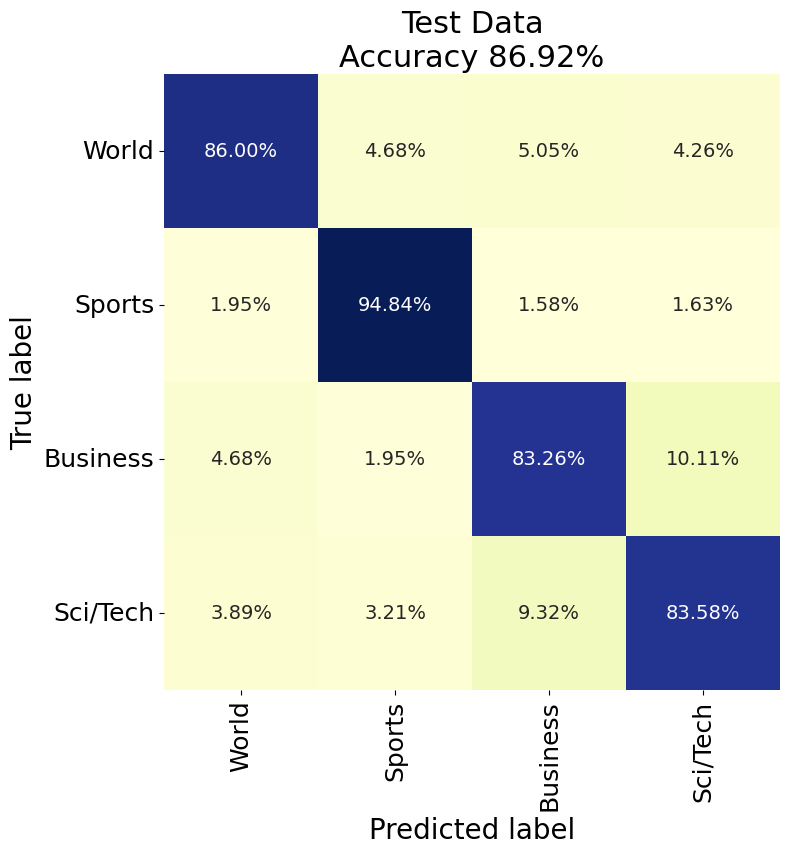

In [79]:
# Load the logits to make the prediction
best_train_logits = np.loadtxt(os.path.join('Logits', f'Train_Model_{best_model_idx + 1}.csv'), delimiter=',')
best_test_logits = np.loadtxt(os.path.join('Logits', f'Test_Model_{best_model_idx+1}.csv'), delimiter=',')
best_train_probs = softmax(best_train_logits)
best_test_probs = softmax(best_test_logits)

# Train data
cf = confusion_matrix(df_clean['Class'].values, best_train_probs.argmax(1), normalize='true')
acc = accuracy_score(df_clean['Class'].values, best_train_probs.argmax(1), normalize=True)
_, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(cf, annot=True, cbar=False, 
            square=True, ax=ax, annot_kws={'fontsize': 14}, 
            fmt='.2%', cmap='YlGnBu')
ax.set_xticklabels(classes, fontsize=18, rotation=90)
ax.set_yticklabels(classes, fontsize=18, rotation=0)
ax.set_xlabel('Predicted label', fontsize=20)
ax.set_ylabel('True label', fontsize=20)
ax.set_title('Train Data\nAccuracy {:,.2%}'.format(acc), fontsize=22)
plt.show()

# Test data
cf = confusion_matrix(df_test['Class'].values, best_test_probs.argmax(1), normalize='true')
acc = accuracy_score(df_test['Class'].values, best_test_probs.argmax(1), normalize=True)
_, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(cf, annot=True, cbar=False, 
            square=True, ax=ax, annot_kws={'fontsize': 14}, 
            fmt='.2%', cmap='YlGnBu')
ax.set_xticklabels(classes, fontsize=18, rotation=90)
ax.set_yticklabels(classes, fontsize=18, rotation=0)
ax.set_xlabel('Predicted label', fontsize=20)
ax.set_ylabel('True label', fontsize=20)
ax.set_title('Test Data\nAccuracy {:,.2%}'.format(acc), fontsize=22)
plt.show()

The confusion matrices above show the performance of the best model using the training data and testing data. The model yielded a high prediction accuracy for both training and test data, with 92.8% and 86.9%, respectively. With the grid search, we found some optimal parameters for the text classification task. It is noticed that, the most important parameter for this assignment was the size of the vocabulary. A small vocabulary size (e.g., 100 words) was not enough for a good prediction. However, a huge vocabulary (e.g., 10k words) made the model bigger and therefore more difficult to train. We can further demonstrate this by using as baseline the best model, and changing only the size of the vocabulary.

In [85]:
test_vocab_sizes = [100, 1000, 10000, 100000]
vocab_train_acc = []
vocab_test_acc = []
for features_size in test_vocab_sizes:
    print(f'Vocab size {features_size}')

    # Train model
    model = TextClassificationModel(features_size=features_size, 
                                    corpus=df_clean['Text'].values, output_mode='tf_idf', 
                                    dense_layers=[512, 256, 128])
    model.compile(optimizer='adam', 
                  loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    callback = tf.keras.callbacks.EarlyStopping(patience=3)
    history = model.fit(df_clean['Text'].values, (df_clean['Class'].values)[..., None], 
                        epochs=50, batch_size=500, validation_split=0.1, callbacks=[callback])

    # Evaluate model for training data
    print('Evaluating...')
    logits = model.predict(df_clean['Text'], verbose=0)
    probs = softmax(logits)
    train_acc = accuracy_score(df_clean['Class'].values, probs.argmax(1), normalize=True)
    vocab_train_acc.append(train_acc)
    
    # Evaluate model in test data
    logits = model.predict(df_test['Text'], verbose=0)
    probs = softmax(logits)
    test_acc = accuracy_score(df_test['Class'].values, probs.argmax(1), normalize=True)
    vocab_test_acc.append(test_acc)
    
    print('Train acc {:,.2%}\tTest acc {:,.2%}'.format(train_acc, test_acc))

    print() 
    del model

Vocab size 100
Epoch 1/50
216/216 [==============================] - 2s 4ms/step - loss: 1.1671 - accuracy: 0.5154 - val_loss: 0.9850 - val_accuracy: 0.5910
Epoch 2/50
216/216 [==============================] - 1s 4ms/step - loss: 0.9402 - accuracy: 0.6110 - val_loss: 0.9495 - val_accuracy: 0.6172
Epoch 3/50
216/216 [==============================] - 1s 3ms/step - loss: 0.9136 - accuracy: 0.6240 - val_loss: 0.9423 - val_accuracy: 0.6151
Epoch 4/50
216/216 [==============================] - 1s 3ms/step - loss: 0.9006 - accuracy: 0.6290 - val_loss: 0.9265 - val_accuracy: 0.6180
Epoch 5/50
216/216 [==============================] - 1s 3ms/step - loss: 0.8876 - accuracy: 0.6356 - val_loss: 0.9197 - val_accuracy: 0.6213
Epoch 6/50
216/216 [==============================] - 1s 3ms/step - loss: 0.8767 - accuracy: 0.6414 - val_loss: 0.9120 - val_accuracy: 0.6272
Epoch 7/50
216/216 [==============================] - 1s 3ms/step - loss: 0.8671 - accuracy: 0.6451 - val_loss: 0.9208 - val_accuracy

Text(0, 0.5, '$\\Sigma$ Acc')

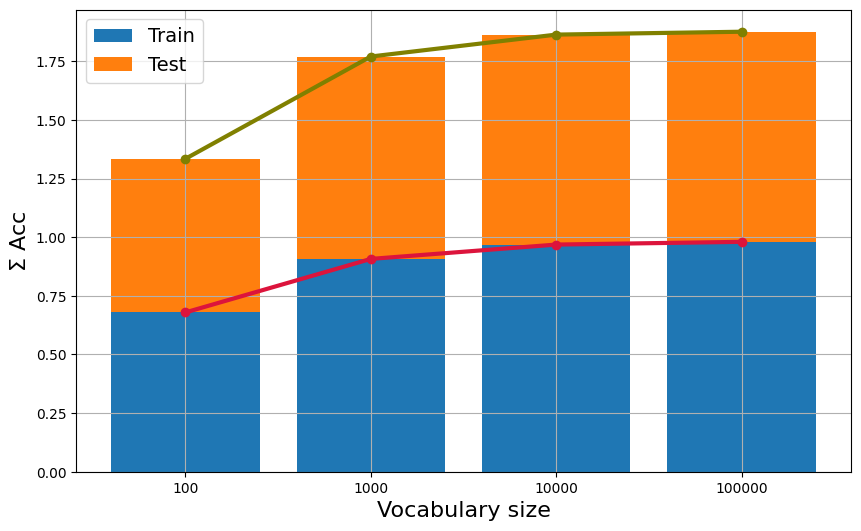

In [119]:
# Visualize the accuracy vs vocabulary size
vocab_train_acc = np.array(vocab_train_acc)
vocab_test_acc = np.array(vocab_test_acc)
plt.figure(figsize=(10, 6))
plt.bar([i for i in range(4)], vocab_train_acc, tick_label=test_vocab_sizes, bottom=np.zeros(4), label='Train')
plt.bar([i for i in range(4)], vocab_test_acc, bottom=vocab_train_acc, tick_label=test_vocab_sizes, label='Test')
plt.plot(vocab_train_acc, '-o', c='crimson', linewidth=3)
plt.plot(vocab_test_acc + vocab_train_acc, '-o', c='olive', linewidth=3)
#plt.scatter
plt.legend(fontsize=14)
plt.grid()
plt.xlabel('Vocabulary size', fontsize=16)
plt.ylabel('$\Sigma$ Acc', fontsize=16)

The plot above shows the accuracy of the best model while changing the vocabulary size. It is noticed that the greater the vocabulary size, the most accurate predictions. However, creating a bigger vocabulary consumes much more RAM and it takes longer. Moreover, the more parameters the model has, the more likely we can overfit during training. We can observe this behavior in the training phase, where the model with vocabulary size of 100 words took 15 epochs to trigger the early stopping criteria, while the model with vocabulary size of 100k words took only 4 epochs to trigger the early stopping. Given this, we will set for a vocabulary size of 10k words. 

## Train Best Model 

In [120]:
model = TextClassificationModel(features_size=10000, corpus=df_clean['Text'].values, 
                                output_mode='tf_idf', dense_layers=[512, 256, 128])
model.compile(optimizer='adam', 
                  loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(patience=3)
history = model.fit(df_clean['Text'].values, (df_clean['Class'].values)[..., None], 
                    epochs=50, batch_size=500, validation_split=0.1, callbacks=[callback])
model.save(os.path.join('Models', 'Best Model'))

Epoch 1/50
216/216 [==============================] - 2s 7ms/step - loss: 0.3591 - accuracy: 0.8819 - val_loss: 0.2933 - val_accuracy: 0.8927
Epoch 2/50
216/216 [==============================] - 1s 7ms/step - loss: 0.2031 - accuracy: 0.9295 - val_loss: 0.3230 - val_accuracy: 0.8852
Epoch 3/50
216/216 [==============================] - 1s 7ms/step - loss: 0.1451 - accuracy: 0.9468 - val_loss: 0.3659 - val_accuracy: 0.8877
Epoch 4/50
216/216 [==============================] - 2s 7ms/step - loss: 0.1067 - accuracy: 0.9592 - val_loss: 0.4656 - val_accuracy: 0.8811
INFO:tensorflow:Assets written to: Models/Best Model/assets


In [123]:
model.summary(expand_nested=True)

Model: "text_classification_model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_33 (Text  multiple                 1         
 Vectorization)                                                  
                                                                 
 lambda_18 (Lambda)          multiple                  0         
                                                                 
 sequential_58 (Sequential)  (None, 128)               5284736   
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| dense_94 (Dense)          (None, 512)               5120512   |
|                                                               |
| dropout_65 (Dropout)      (None, 512)               0         |
|                                                               |
| dense_95 (Dense)          (None, 256)               131328    |
|                                     

Given the large size of the vocabulary, the model has a large number of trainable parameters (5M). This is a huge model, compared with the baseline model, which had less than 500k parameters.

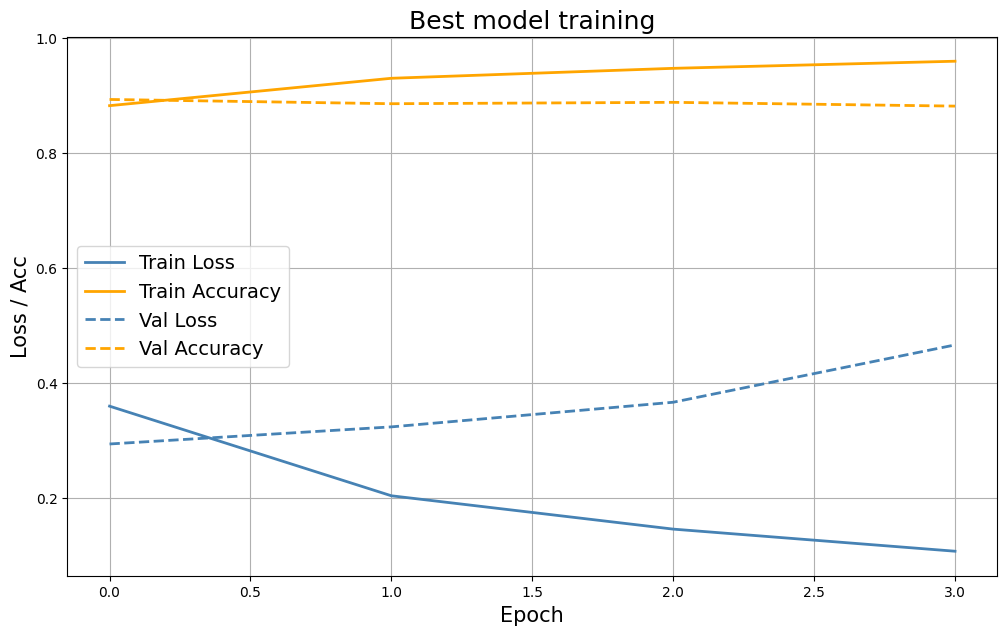

In [121]:
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], linewidth=2, c='steelblue', label='Train Loss')
plt.plot(history.history['accuracy'], linewidth=2, c='orange', label='Train Accuracy')
plt.plot(history.history['val_loss'], '--', linewidth=2, c='steelblue', label='Val Loss')
plt.plot(history.history['val_accuracy'], '--', linewidth=2, c='orange', label='Val Accuracy')
plt.legend(fontsize=14)
plt.title('Best model training', fontsize=18)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss / Acc', fontsize=15)
plt.grid()

The training plot above shows that the training was successful. However, we can also notice that the model started to overfit. The early stopping strategy helped to avoid the overfitting.

# Testing 

This section tests only the best model! All the data and weights of each individual model can be downloaded from https://github.com/sololzano/DM_Assignment_3. The models are saved in compressed Zip file called "Models.zip". However, we will assume the weights / model are saved in the directory "Models/Best Model". In any case the training code cannot be run (GPU limitations, time limitations, TF version incorrect, etc.), we will retrieve and preprocess the data once again.

In [126]:
# Import the data from my personal GitHub
df = pd.read_csv('https://media.githubusercontent.com/media/sololzano/DM_Assignment_3/main/ag_news_csv/train.csv', 
                 names=['Class', 'Title', 'Description'], header=None)
r = requests.get('https://raw.githubusercontent.com/sololzano/DM_Assignment_3/main/ag_news_csv/classes.txt')
classes = r.text.split()
print(classes)
df.head()

['World', 'Sports', 'Business', 'Sci/Tech']


,Class,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [127]:
# Pre-process the dataframe
df_clean = preprocess(df.copy())
print(df_clean.shape)
df_clean.head()

(120000, 2)


,Class,Text
0,2,wall st. bears claw back into the black short-...
1,2,carlyle looks toward commercial aerospace priv...
2,2,oil and economy cloud stocks' outlook soaring ...
3,2,iraq halts oil exports from main southern pipe...
4,2,"oil prices soar to all-time record, posing new..."


In [128]:
# Retrieve the test data and preprocess it
df_test = pd.read_csv('https://media.githubusercontent.com/media/sololzano/DM_Assignment_3/main/ag_news_csv/test.csv', 
                      names=['Class', 'Title', 'Description'], header=None)
df_test = preprocess(df_test)
df_test.head()

,Class,Text
0,2,fears for t n pension after talks unions repre...
1,3,the race is on: second private team sets launc...
2,3,ky. company wins grant to study peptides a com...
3,3,prediction unit helps forecast wildfires it's ...
4,3,calif. aims to limit farm-related smog souther...


In [131]:
# Load model from the saved session
model = tf.keras.models.load_model(os.path.join('Models', 'Best Model'))
model.summary(expand_nested=True)

Model: "text_classification_model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_33 (Text  multiple                 1         
 Vectorization)                                                  
                                                                 
 lambda_18 (Lambda)          multiple                  0         
                                                                 
 sequential_58 (Sequential)  (None, 128)               5284736   
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| dense_94 (Dense)          (None, 512)               5120512   |
|                                                               |
| dropout_65 (Dropout)      (None, 512)               0         |
|                                                               |
| dense_95 (Dense)          (None, 256)               131328    |
|                                     

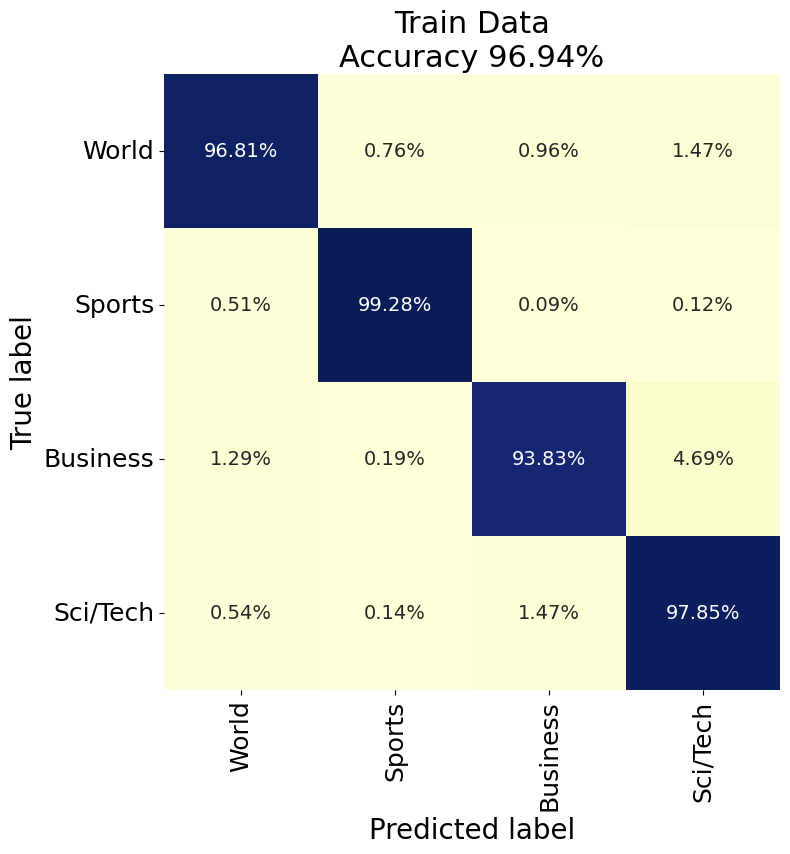

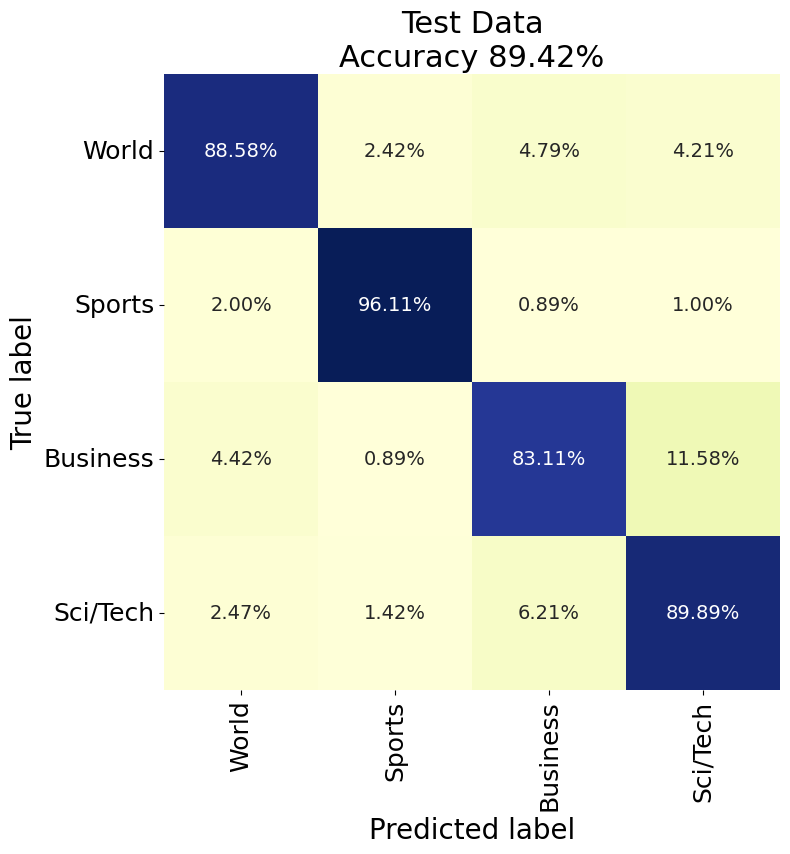

In [136]:
# Predict train and test data
train_probs = softmax(model(df_clean['Text'], training=False))
test_probs = softmax(model(df_test['Text'], training=False))

# Train data
cf = confusion_matrix(df_clean['Class'].values, train_probs.argmax(1), normalize='true')
acc = accuracy_score(df_clean['Class'].values, train_probs.argmax(1), normalize=True)
_, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(cf, annot=True, cbar=False, 
            square=True, ax=ax, annot_kws={'fontsize': 14}, 
            fmt='.2%', cmap='YlGnBu')
ax.set_xticklabels(classes, fontsize=18, rotation=90)
ax.set_yticklabels(classes, fontsize=18, rotation=0)
ax.set_xlabel('Predicted label', fontsize=20)
ax.set_ylabel('True label', fontsize=20)
ax.set_title('Train Data\nAccuracy {:,.2%}'.format(acc), fontsize=22)
plt.show()

# Test data
cf = confusion_matrix(df_test['Class'].values, test_probs.argmax(1), normalize='true')
acc = accuracy_score(df_test['Class'].values, test_probs.argmax(1), normalize=True)
_, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(cf, annot=True, cbar=False, 
            square=True, ax=ax, annot_kws={'fontsize': 14}, 
            fmt='.2%', cmap='YlGnBu')
ax.set_xticklabels(classes, fontsize=18, rotation=90)
ax.set_yticklabels(classes, fontsize=18, rotation=0)
ax.set_xlabel('Predicted label', fontsize=20)
ax.set_ylabel('True label', fontsize=20)
ax.set_title('Test Data\nAccuracy {:,.2%}'.format(acc), fontsize=22)
plt.show()

The highest accuracy obtained for the test data was 89.4%, with the best predictioni rate being the <b>Sports</b> class (96.1%). The model did not overfit, and learned the general idea of the text to classify the news into their respective category.

# Summary and Conclusions

The focus of the assignment was the classification of news (text data) into categories. The text data was preprocessed and prepared before the training of a classifier. Then, the preprocessed text was vectorized. Two approaches were evaluated, integer indexing and TF-IDF algorithm. The vectorized text was the input to an Artificial Neural Network for the classification task. The optimization process was done through the ADAM algorithm, with the objective function being the Crossentropy (classification task). Experimental results show that the TF-IDF vectorization algorithm performed better than the integer indexing, with a high accuracy of 89.4%. The models were trained in a personal computer running Ubuntu 22.04, with Tensorflow 2.12.0 as the deep learning framework. The hardware used is shown in the table below. 

|     | Hardware             | Specs.      |
|-----|----------------------|-------------|
| CPU | Intel Core i7-12700K | 20 @ 4.0GHz |
| RAM | -                    | 32 GB       |
| GPU | Nvidia RTX 3060      | 12 GB VRAM  |